# Training model with files from dataset

In [234]:
import re
import os
import glob
import nltk
from nltk.util import ngrams, pad_sequence, everygrams
from nltk.tokenize import word_tokenize
from nltk.lm import MLE, WittenBellInterpolated
import numpy as np
import PyPDF2
import docx
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from enum import Enum 
import textract
import os.path




#--------------------------------------------------------------------------------------------------
#------------------------------------------ FUNCTIONS ---------------------------------------------
#--------------------------------------------------------------------------------------------------




#TOKENIZE TEXT 
def tokenize(text):
    return [word for word in word_tokenize(text) if re.search("\w",	word)]


#CLEANING  AND TOKENIZE TEXT
def cleaning_and_tokenize(text, model):
    text = with_out_punct(text)
    training_data =  tokenize(text)
    ngrams = list(everygrams(training_data, max_len=n))
    model.fit([ngrams], vocabulary_text=training_data)


#CLEANING TEXT 
def with_out_punct(text):
    text = re.sub(r"\[.*\]|\{.*\}", "", text)
    return re.sub(r'[^\w\s]', "", text)



#ASSIGN SCORES 
def assign_scores(data, model):
    scores = []
    for i, item in enumerate(data[n-1:]):
        s = model.score(item, data[i:i+n-1])
        scores.append(s)

    return  np.array(scores)


    



#GRAPHIC

def calculate_height(data):
    return  np.ceil(len(data)/width).astype("int32")

def copy_scores(scores,height):
    a = np.zeros(width*height)
    print(height)
    a[:len(scores)] = scores
    # apply gaussian smoothing for aesthetics
    a = gaussian_filter(a, sigma=1.0)
    # reshape to fit rectangle
    a = a.reshape(-1, width)
    return len(a) - len(scores)


def format_labels(data, diff):
    labels = [" ".join(data[i:i+width]) for i in range(n-1, len(data), width)]
    labels_individual = [x.split() for x in labels]
    labels_individual[-1] += [""]*diff
    return [f"{x:60.60}" for x in labels]

def heat_map(labels):
    fig = go.Figure(data=go.Heatmap(
                    z=a, x0=0, dx=1,
                    y=labels, zmin=0, zmax=1,
                    customdata=labels_individual,
                    hovertemplate='%{customdata} <br><b>Score:%{z:.3f}<extra></extra>',
                    colorscale="burg"))
    fig.update_layout({"height":height*28, "width":1000, "font":{"family":"Courier New"}})
    fig['layout']['yaxis']['autorange'] = "reversed"
    fig.show()    

def graphic(scores, data, height):
    diff = copy_scores(scores, height)  
    labels =  format_labels(data, diff)
    heat_map(labels)
    
    
#-------------------------------------- PDF --------------------------------------


def read_pdf(path):
    with open(path, "rb") as f:
        pdf = PyPDF2.PdfFileReader(f)
        NumPages = pdf.getNumPages()
        output = []
        print("Text: count of total pages : ",  NumPages) 
        for i in range(0, NumPages):
            pageObj = pdf.getPage(i)
            output.append( pageObj.extractText().lower() )
            train_text = " ".join(output)
        f.close()
        return train_text

    
#-------------------------------------- DOCX --------------------------------------

def read_docx(path):
    doc = docx.Document(path)
    full_text = []
    for i in doc.paragraphs:
        full_text.append(i.text.lower())
    return '\n'.join(full_text)
    

        


#--------------------------------------------------------------------------------------------------


os.chdir("C:\\Users\\HP\Desktop\\UTN\\PROCESAMIENTO LENGUAJE NATURAL\\dataset-nlp-plagio-utn\\")


# set ngram number
n = 4

#Initialize model
model = WittenBellInterpolated(n)

#Train model with all pdf files from dataset
for name in glob.glob("*.pdf"):
    print("Leyendo el archivo %s" % name)
    train_text = read_pdf(name)
    cleaning_and_tokenize(train_text, model)
    
#Train model with all docs files from dataset
for name in glob.glob("*.docx"):
    print("Leyendo el archivo %s" % name)
    train_text = read_docx(name)
    cleaning_and_tokenize(train_text, model)

for name in glob.glob("*.doc"):
    print("Leyendo el archivo %s" % name)
    train_text = textract.process(name).decode("utf-8")
    cleaning_and_tokenize(train_text, model)



#PATH AND FILENAMES
    
name_of_test_file = 'Mkt_JourdanMartin_Tp1.docx'
train_path_name = 'C:\\Users\\HP\\Desktop\\UTN\\PROCESAMIENTO LENGUAJE NATURAL\\dataset-nlp-plagio-utn\\Mkt_JourdanMartin_Tp1.docx'
testing_path_name = str('C:\\Users\\HP\Desktop\\UTN\\PROCESAMIENTO LENGUAJE NATURAL\\dataset-nlp-plagio-utn\\' + name_of_test_file)

scores = []
width = 8
    


Leyendo el archivo Economía de experiencia (1).pdf
Text: count of total pages :  4
Leyendo el archivo Economía de experiencia.pdf
Text: count of total pages :  4
Leyendo el archivo K5071 - Matias David Choren - TP N6 Sistemas Emergentes (1).pdf
Text: count of total pages :  3
Leyendo el archivo K5071 - Matias David Choren - TP N6 Sistemas Emergentes.pdf
Text: count of total pages :  3
Leyendo el archivo K5071 - Matias David Choren - TP N°5 Rifkin (1).pdf
Text: count of total pages :  4
Leyendo el archivo K5071 - Matias David Choren - TP N°5 Rifkin.pdf
Text: count of total pages :  4
Leyendo el archivo K5071 - Matias David Choren - TP3 - Experience Economy.pdf
Text: count of total pages :  7
Leyendo el archivo MKT 2016 - Alan Szpigiel - TP4 (1).pdf
Text: count of total pages :  4
Leyendo el archivo MKT 2016 - Alan Szpigiel - TP4 (2).pdf
Text: count of total pages :  4
Leyendo el archivo MKT 2016 - Alan Szpigiel - TP4 (3).pdf
Text: count of total pages :  4
Leyendo el archivo MKT 2016 - 

# Training lda model to create a dictonary

In [ ]:
import spacy
import re
import spacy_spanish_lemmatizer
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import PyPDF2
import os
import docx
import glob
import numpy as np
import textract
np.random.seed(400)
nlp = spacy.load('en_core_web_sm')
 
stopword_es = nltk.corpus.stopwords.words('spanish')

import pandas as pd

stemmer = SnowballStemmer("spanish")


#Write a function to perform the pre processing steps on the entire dataset

def lemmatize_stemming(token):
    return token.lemma_

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    text_no_digits = ''.join([i for i in text if not i.isdigit()])
    for token in nlp(text_no_digits) :
        #print(token.lemma_)
        if token.text not in stopword_es and len(token.text) > 3 and not "\n" in token.text and not " " in token.text:
            result.append(token.lemma_)
            
    return result

 
document_num = 50
doc_sample = "Un sistema de archivos o sistema de ficheros"

words = []
for word in doc_sample.split(' '):
    words.append(word)


processed_docs = []

os.chdir("C:\\Users\\HP\Desktop\\UTN\\PROCESAMIENTO LENGUAJE NATURAL\\dataset-nlp-plagio-utn\\")
#CLEANING TEXT 
def with_out_punct(text):
    text = re.sub(r"\[.*\]|\{.*\}", "", text)
    return re.sub(r'[^\w\s]', "", text)

def read_pdf(path):
    with open(path, "rb") as f:
        pdf = PyPDF2.PdfFileReader(f)
        NumPages = pdf.getNumPages()
        output = []
   
        for i in range(0, NumPages):
            pageObj = pdf.getPage(i)
            output.append( pageObj.extractText().lower() )
            train_text = " ".join(output)
        f.close()
        return with_out_punct(train_text)
    
def read_docx(path):
    doc = docx.Document(path)
    full_text = []
    for i in doc.paragraphs:
        full_text.append(i.text.lower())
    return '\n'.join(full_text)
    

#Train model with all   files from dataset

for name in glob.glob("*.doc"):
    trainText = textract.process(name).decode("utf-8")
    processed_docs.append(preprocess(train_text))

for name in glob.glob("*.pdf"):
    train_text = read_pdf(name)
    processed_docs.append(preprocess(train_text))
    
for name in glob.glob("*.docx"):
    train_text = read_docx(name)
    processed_docs.append(preprocess(train_text))
    


    

#Create a dictionary from 'processed_docs' containing the number of times a word appears 
#in the training set using gensim.corpora.Dictionary and call it 'dictionary'

dictionary = gensim.corpora.Dictionary(processed_docs)



# Training lda model using gensim.models.LdaMulticore and showing the main topics 

In [161]:

#Remove very rare and very common words:
#- words appearing less than 15 times
#- words appearing in more than 10% of all documents



dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n= 100000)



#Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
#words and how many times those words appear. Save this to 'bow_corpus'


bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

 
document_num = 0
bow_doc_x = bow_corpus[document_num]

    


#Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
 
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

#For each topic, we will explore the words occuring in that topic and its relative weight

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")



Topic: 0 
Words: 0.008*"ciento" + 0.008*"boca" + 0.007*"aspiraciones" + 0.006*"adoptada" + 0.006*"n(t-" + 0.006*"análisis" + 0.006*"potenciales" + 0.005*"compre" + 0.005*"lídere" + 0.005*"llamado"


Topic: 1 
Words: 0.011*"adoptan" + 0.010*"plantea" + 0.009*"organismo" + 0.008*"conductas" + 0.008*"arriesgado" + 0.008*"propensión" + 0.008*"acotada" + 0.007*"aquel" + 0.007*"ecuación" + 0.007*"observan"


Topic: 2 
Words: 0.018*"kotler" + 0.014*"marca" + 0.014*"marcas" + 0.014*"línea" + 0.013*"conectividad" + 0.011*"posicionamiento" + 0.010*"uber" + 0.010*"vertical" + 0.010*"promesa" + 0.008*"inteligencia"


Topic: 3 
Words: 0.010*"comprometer" + 0.007*"memorable" + 0.007*"pine" + 0.007*"real" + 0.007*"gilmore" + 0.007*"absoluto" + 0.006*"joseph" + 0.006*"exploratoria" + 0.006*"gratificante" + 0.006*"elusiva"


Topic: 4 
Words: 0.012*"nicho" + 0.010*"costes" + 0.009*"populare" + 0.009*"democratizar" + 0.008*"netflix" + 0.008*"éxitos" + 0.007*"popularidad" + 0.006*"inventario" + 0.006*"tie

# Topic with the highest percentage

In [172]:
list_topics =  []
for i in range(8):
    topics_with_num = with_out_punct(lda_model.print_topic(i))
    topics = ''.join([i for i in topics_with_num if not i.isdigit()])
    list_topics.append(topics)
    print("\n ->Topics: ", i)
    print(list_topics[i])
    

#New text debe ser el texto del archivo a testear
new_text = testing_text
tokens = [stemmer.stem(token) for token in preprocess(new_text.lower())]
total_topics = lda_model[dictionary.doc2bow(tokens)]


max_topic_tuple = max(total_topics, key=lambda e: e[1])
max_topic = max_topic_tuple[0]
print("\n---------------------------------------------------------------------------------------------------------------------------- ")
print("\nNumber of topic with the highest percentage:  ")
print(max_topic)
print("\n----------------------------------------------------------------------------------------------------------------------------- ")
topic_to_find = list_topics[max_topic]
print("\nText of topic with the highest percentage:  ")
print(topic_to_find)




 ->Topics:  0
ciento  boca  aspiraciones  adoptada  nt  análisis  potenciales  compre  lídere  llamado

 ->Topics:  1
adoptan  plantea  organismo  conductas  arriesgado  propensión  acotada  aquel  ecuación  observan

 ->Topics:  2
kotler  marca  marcas  línea  conectividad  posicionamiento  uber  vertical  promesa  inteligencia

 ->Topics:  3
comprometer  memorable  pine  real  gilmore  absoluto  joseph  exploratoria  gratificante  elusiva

 ->Topics:  4
nicho  costes  populare  democratizar  netflix  éxitos  popularidad  inventario  tienda  reducir

 ->Topics:  5
moho  ascendente  organismo  complejas  agente  fango  morfogénesis  conductas  centrale  david

 ->Topics:  6
transacción  global  termodinámica  coase  desarrolle  emergencia  propiedad  autoselección  procomún  tareas

 ->Topics:  7
bbrroossii  mmaarrcceelloo  argentina  commerce  millone  adopci  dólare  unido  porcentaje  juan

--------------------------------------------------------------------------------------------

# Searching links related to the topic with the highest percentage

In [174]:
from googlesearch import search

# to search 
query = topic_to_find

links = []
for j in search(query, num=10, stop=10, pause=2): 
    links.append(j) 

print("Links related: ")
print(links)

Links related: 
['https://economipedia.com/definiciones/teorema-de-coase.html', 'https://es.wikipedia.org/wiki/Teorema_de_Coase', 'http://www.asociacioneconomiacritica.org/wp-content/uploads/2021/08/Libro-de-Actas-XVII-JEC.pdf']


# Extracting text from web pages

In [188]:
import requests
from bs4 import BeautifulSoup

url = 'https://es.wikipedia.org/wiki/Teorema_de_Coase'
res = requests.get(url)
html_page = res.content
soup = BeautifulSoup(html_page, 'html.parser')
text = soup.find_all(text=True)

output = ''
blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
 
]

for t in text:
    if t.parent.name not in blacklist:
        output += '{} '.format(t)

web_text = re.sub(r'\n', '', output)
tokenize_token = cleaning_and_tokenize(web_text, model)


Testing file name:
Mkt_JourdanMartin_Tp1.docx


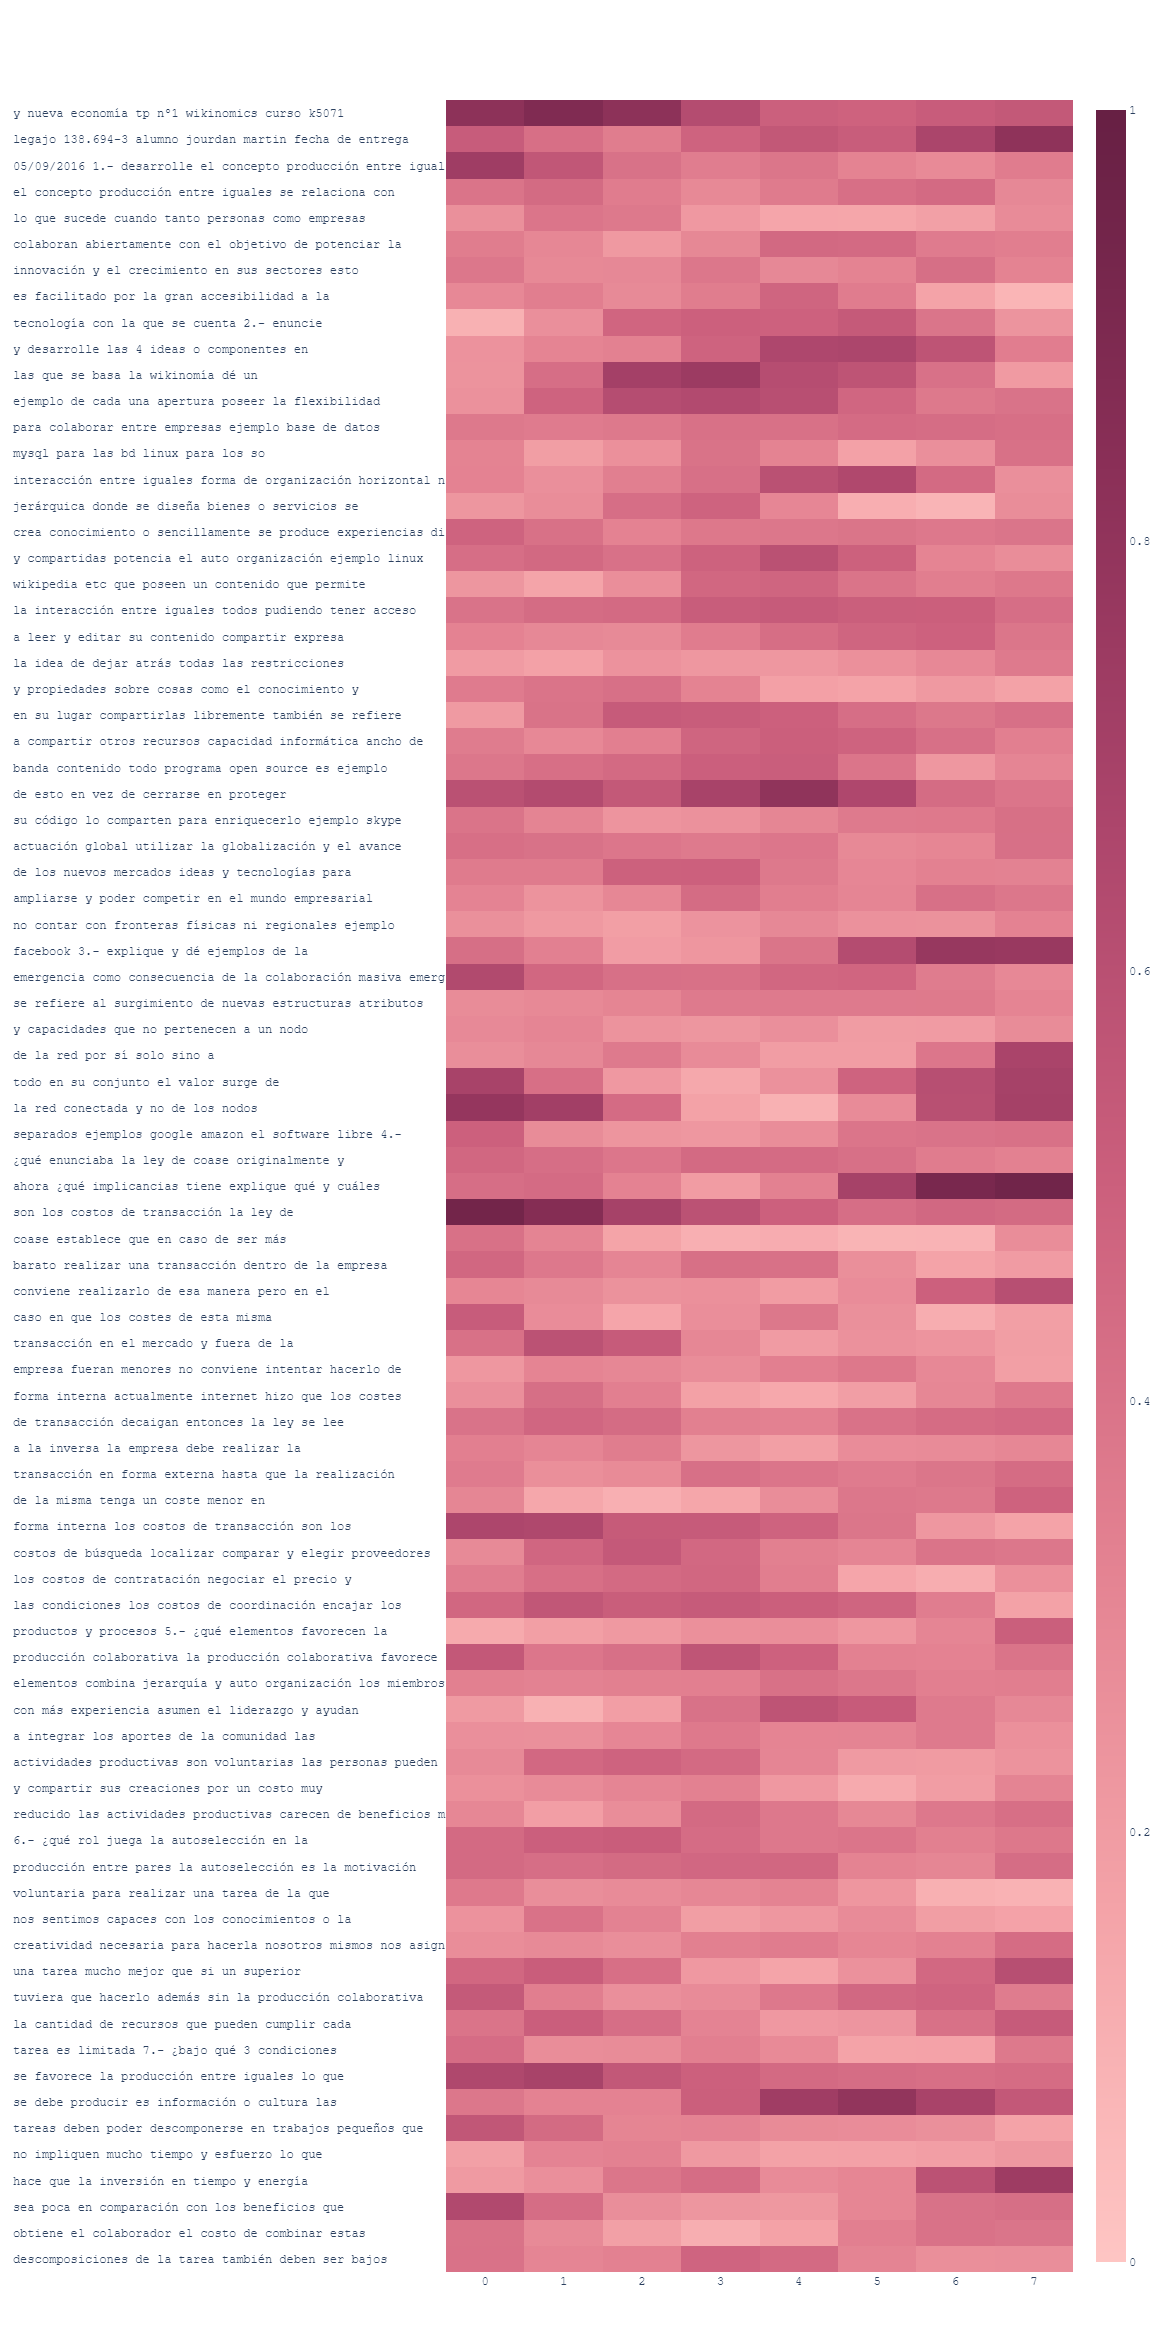

In [242]:
extension_text = os.path.splitext(name_of_test_file)[1][1:]


if extension_text == "pdf":
    
    # Read testing data
    testing_text = read_pdf(testing_path_name)

    # Tokenize and pad the text
    testing_data =  tokenize(testing_text)
    
    scores_np = assign_scores(testing_data, model)
 
    height = np.ceil(len(testing_data)/width).astype("int32")
    
    print("Testing file name:")
    print(name_of_test_file)
    
    # copy scores to rectangular blank array
    a = np.zeros(width*height)
   
    a[:len(scores_np)] = scores_np
    diff = len(a) - len(scores_np)

    # apply gaussian smoothing for aesthetics
    a = gaussian_filter(a, sigma=1.0)

    # reshape to fit rectangle
    a = a.reshape(-1, width)

    # format labels
    labels = [" ".join(testing_data[i:i+width]) for i in range(n-1, len(testing_data), width)]
    labels_individual = [x.split() for x in labels]
    labels_individual[-1] += [""]*diff
    labels = [f"{x:60.60}" for x in labels]

    # create heatmap
    fig = go.Figure(data=go.Heatmap(
                    z=a, x0=0, dx=1,
                    y=labels, zmin=0, zmax=1,
                    customdata=labels_individual,
                    hovertemplate='%{customdata} <br><b>Score:%{z:.3f}<extra></extra>',
                    colorscale="burg"))
    fig.update_layout({"height":height*28, "width":1000, "font":{"family":"Courier New"}})
    fig['layout']['yaxis']['autorange'] = "reversed"
    fig.show()
   
    
elif extension_text == "docx":
    
    print("Testing file name:")
    print(name_of_test_file)
    
    # Read testing data
    testing_text = read_docx(testing_path_name)
    
    # Tokenize and pad the text
    testing_data =  tokenize(testing_text)

    scores_np = assign_scores(testing_data, model)
  
    
    height = np.ceil(len(testing_data)/width).astype("int32")
    
    
    # copy scores to rectangular blank array
    a = np.zeros(width*height)
 
    a[:len(scores_np)] = scores_np
    diff = len(a) - len(scores_np)

    # apply gaussian smoothing for aesthetics
    a = gaussian_filter(a, sigma=1.0)

    # reshape to fit rectangle
    a = a.reshape(-1, width)

    # format labels
    labels = [" ".join(testing_data[i:i+width]) for i in range(n-1, len(testing_data), width)]
    labels_individual = [x.split() for x in labels]
    labels_individual[-1] += [""]*diff
    labels = [f"{x:60.60}" for x in labels]

    # create heatmap
    fig = go.Figure(data=go.Heatmap(
                    z=a, x0=0, dx=1,
                    y=labels, zmin=0, zmax=1,
                    customdata=labels_individual,
                    hovertemplate='%{customdata} <br><b>Score:%{z:.3f}<extra></extra>',
                    colorscale="burg"))
    fig.update_layout({"height":height*28, "width":1000, "font":{"family":"Courier New"}})
    fig['layout']['yaxis']['autorange'] = "reversed"
    fig.show() 
 
    
elif extension_text == "doc":
     
    print("Testing file name:")
    
    print(name_of_test_file)
    
    # Read testing data
    testing_text = read_docx(testing_path_name)
    
    # Tokenize and pad the text
    testing_data =  tokenize(testing_text)

    scores_np = assign_scores(testing_data, model)
     
    height = np.ceil(len(testing_data)/width).astype("int32")
   
    # copy scores to rectangular blank array
    a = np.zeros(width*height)
  
    a[:len(scores_np)] = scores_np
    diff = len(a) - len(scores_np)

    # apply gaussian smoothing for aesthetics
    a = gaussian_filter(a, sigma=1.0)

    # reshape to fit rectangle
    a = a.reshape(-1, width)

    # format labels
    labels = [" ".join(testing_data[i:i+width]) for i in range(n-1, len(testing_data), width)]
    labels_individual = [x.split() for x in labels]
    labels_individual[-1] += [""]*diff
    labels = [f"{x:60.60}" for x in labels]

    # create heatmap
    fig = go.Figure(data=go.Heatmap(
                    z=a, x0=0, dx=1,
                    y=labels, zmin=0, zmax=1,
                    customdata=labels_individual,
                    hovertemplate='%{customdata} <br><b>Score:%{z:.3f}<extra></extra>',
                    colorscale="burg"))
    fig.update_layout({"height":height*28, "width":1000, "font":{"family":"Courier New"}})
    fig['layout']['yaxis']['autorange'] = "reversed"
    fig.show() 
else: 
    print("Error")

In [150]:
import pdftotext
from urllib.request import urlopen

target_url = "https://www.colibri.udelar.edu.uy/jspui/bitstream/20.500.12008/23309/1/TCP_GuerreroAlvaro.pdf" #  to change.
file = urlopen(target_url)

pdf = pdftotext.PDF(file) # add password if password protected.

# How many pages?
print(len(pdf))

# Iterate over all the pages
for page in pdf:
    print(page)

# Read some individual pages
print(pdf[0])
print(pdf[1])

# Read all the text into one string
print("\n\n".join(pdf))

ModuleNotFoundError: No module named 'pdftotext'